In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse.linalg import eigs

%matplotlib inline

In [2]:
anime = pd.read_csv('../data/anime-recommendations-database/anime.csv')

In [3]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
print(anime.shape)

(12294, 7)


In [5]:
user = pd.read_csv('../data/anime-recommendations-database/rating.csv')

In [6]:
user.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [7]:
print(user.shape)

(7813737, 3)


In [8]:
# 암시적(implicit) 평가 데이터 제외 (rating=-1)
user = user[user['rating'] != -1]

In [9]:
# 모든 rating 값의 평균

user['rating'].mean()

7.808496946857473

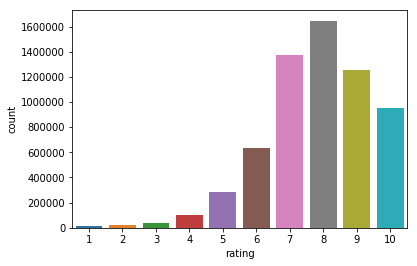

In [10]:
sns.countplot(x='rating', data=user)
plt.show()

In [11]:
# 유저가 평가한 작품 중 고평가를 한 작품만 추출
# 고평가의 기준은 8점 이상을 매긴 작품

user = user[user['rating'] >= 8]
user = user.rename({'rating':'userRating'}, axis='columns')
print(user.shape)

(3855830, 3)


In [12]:
# 메모리 문제로 데이터 사이즈 축소

user = user[user['user_id'] <= 20000]

In [13]:
# 애니메이션 이름 병합
user = pd.merge(user, anime[['anime_id', 'name']], on=['anime_id', 'anime_id'], how='left')
user.head()

,user_id,anime_id,userRating,name
0,1,8074,10,Highschool of the Dead
1,1,11617,10,High School DxD
2,1,11757,10,Sword Art Online
3,1,15451,10,High School DxD New
4,2,11771,10,Kuroko no Basket


In [14]:
user_anime_pivot = user.pivot_table(index='user_id', columns='name', values='userRating', fill_value=0, aggfunc=np.mean)

In [15]:
print(user_anime_pivot.shape)
user_anime_pivot.head(10)

(18726, 7128)


name,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,...,gdgd Fairies,gdgd Fairies 2,gdgd Fairies Movie: tte Iu Eiga wa Dou kana...?,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# 사용 메모리 축소
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    df = df.astype(np.int8)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

reduce_mem_usage(user_anime_pivot)

Memory usage of dataframe is 1018.51 MB
Memory usage after optimization is: 127.44 MB
Decreased by 87.5%


In [20]:
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(user_anime_pivot)

C:\Users\Lee\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [27]:
data_mean = np.mean(data_rescaled)
data_center = data_rescaled - data_mean
cov_matrix = np.cov(np.transpose(data_center))

In [28]:
cov_matrix.shape

(7128, 7128)

In [29]:
eigenvalues_cov, eigenvectors_cov = np.linalg.eig(cov_matrix)

In [34]:
print(eigenvalues_cov, eigenvectors_cov)

[3.40495784e+00+0.j 1.25293775e+00+0.j 8.09760902e-01+0.j ...
 8.37521144e-37+0.j 5.82909324e-36+0.j 7.75830443e-36+0.j] [[ 4.08508420e-03+0.j -4.99037789e-03+0.j -3.85846802e-03+0.j ...
   4.45898535e-17+0.j -7.09199681e-17+0.j  1.24177135e-16+0.j]
 [ 4.93939227e-03+0.j -5.31012560e-03+0.j -4.03845841e-03+0.j ...
  -2.06441391e-17+0.j  3.55923730e-18+0.j  3.35289032e-18+0.j]
 [ 9.69371882e-03+0.j -7.01516161e-03+0.j -2.90107092e-03+0.j ...
  -1.43930232e-17+0.j  2.90442761e-17+0.j -4.63612026e-17+0.j]
 ...
 [ 9.61146477e-03+0.j -2.66133721e-02+0.j -1.11816687e-02+0.j ...
   4.62703066e-18+0.j  6.73282839e-18+0.j -1.07301936e-17+0.j]
 [ 9.37761691e-03+0.j -1.51556729e-02+0.j -3.44021161e-03+0.j ...
  -1.78120931e-17+0.j  1.56767549e-17+0.j -2.52532509e-17+0.j]
 [ 1.04684688e-02+0.j -2.26888794e-02+0.j -9.47283220e-03+0.j ...
   1.56036507e-17+0.j -3.58400480e-17+0.j  6.07618844e-17+0.j]]


In [32]:
idx = eigenvalues_cov.argsort()[::-1]

array([   0,    1,    2, ..., 6059, 6060, 6049], dtype=int64)

In [35]:
eigenvalues_cov = eigenvalues_cov[idx]
eigenvectors_cov = eigenvectors_cov[:,idx]

C:\Users\Lee\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


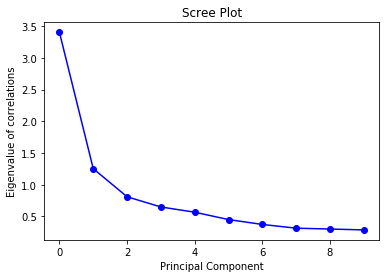

In [45]:
plt.plot(eigenvalues_cov[:10],'bo-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue of correlations')
plt.show()

In [ ]:
user_anime_pivot.to_csv('../data/anime-recommendations-database/anime.csv')